# Discrete and Continuous Control with A2C and PPO

Reinforcement learning (RL) is the study of agents taking actions in an environment in order to increase their "reward". This takes place in a perception-action-learning loop, whereby the agent receives a state/observation at every timestep, uses its policy to choose an action conditional on this observation, and then receives another observation and a scalar reward as the environment transitions to the next timestep. Through multiple interactions with the environment, the goal of the agent is to improve its policy so that it can maximise its expected cumulative reward.

![RL Loop](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/action-perception.png)

Unlike the usual supervised or unsupervised learning settings, the agent is responsible for the data it receives, and so it is far from "independent and identically distributed". Furthermore, there is a particularly difficult credit assignment problem - the agent has to work out which of its actions result in rewards, where the rewards caused by specific actions may appear a long time in the future. Nevertheless, RL provides a formal framework for studying this problem. In contrast to the field of optimal control, we're not assuming that we have access to a (dynamics/forward) model of the environment. RL also includes the concept of model-based methods, which attempt to learn and use such models from data, but that won't be covered here.

Here we'll look at the advantage actor-critic (A2C) algorithm, which combines an explicit policy (the actor) with value function estimation (the critic); the value function captures the expected cumulative reward from a given state and given a certain policy, or more informally how good a state is. We'll also look at a more sophisticated algorithm - proximal policy optimisation (PPO) - that aims to prevent disastrously large updates to the policy.

We'll look at learning to solve two classic control problems - cartpole and pendulum - using A2C. A2C has difficulty in learning to control the pendulum, so we'll show how PPO's more conservative updates actually help solve this.

## Environments

Firstly we'll instantiate the two environments and see how a random policy performs over several rollouts. This'll give us an idea of the problem to solve, as well as how a naive baseline would perform on it. These are both episodic environments, which means that they can terminate at some point. With cartpole, a random policy fails to keep the pole balanced and episodes terminate quickly. With pendulum, a random policy is unlikely to swing the pole up into the upright position, so episodes time out with low rewards.

Just to note - we'll look at renders of the environment, but the observations for the agents will be a few symbolic inputs, such as the angle of the pole in the cartpole environment. However, the ability to learn policies "end-to-end", i.e., directly from pixels, is one of the major success of deep reinforcement learning.

In [1]:
import math
import gym
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.distributions import Categorical, Normal
from torch.nn import functional as F
from IPython.display import clear_output, display
%matplotlib inline
gym.logger.set_level(50)

'Average reward: 14.60'

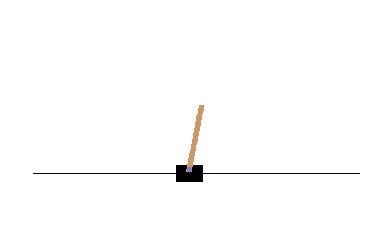

In [2]:
plt.axis('off')

env = gym.make('CartPole-v0')
env.reset()
rollouts = 5
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

# Perform several rollouts/episodes with a random policy
for _ in range(rollouts):
    _, done = env.reset(), False  # Reset the environment to a starting state
    while not done:  # Act until episode terminates
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())  # Sample random (valid) action
        total_reward += reward

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))

'Average reward: -1299.98'

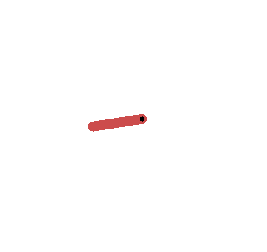

In [3]:
plt.axis('off')

env = gym.make('Pendulum-v0')
env.reset()
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

for _ in range(rollouts):
    _, done = env.reset(), False
    while not done:
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))

## Model

We'll construct two small fully-connected networks (an actor network and critic network) with one hidden layer each for both environments. For discrete control in cartpole (left or right) we'll use a categorical policy, and for continuous control in pendulum (torque) we'll use a Gaussian policy. We'll make the standard deviation of the Gaussian policy independent of the input, which will keep it more stable.

In [9]:
class Agent(nn.Module):
    def __init__(self, obs_size, env):
        super().__init__()
        self.env = env
        # Create separate actor and critic networks in one module (they do not directly interact)
        self.value_fc1 = nn.Linear(obs_size, 256)
        self.value_fc2 = nn.Linear(256, 1)
        self.policy_fc1 = nn.Linear(obs_size, 256)
        self.policy_fc2 = nn.Linear(256, 1 if env == 'pendulum' else 2)
        if env == 'pendulum':
            self.std_dev = nn.Parameter(torch.zeros(1))  # Make the standard deviation a standalone parameter

    def forward(self, obs):
        value = self.value_fc2(torch.tanh(self.value_fc1(obs)))[:, 0]
        policy = self.policy_fc2(torch.tanh(self.policy_fc1(obs)))
        if self.env == 'cartpole':
            policy = Categorical(logits=policy)
        elif self.env == 'pendulum':
            policy = Normal(policy[:, 0], F.softplus(self.std_dev))
        return policy, value

## A2C

### Training and Testing

The first part of A2C training involves taking several rollouts in the environment. The environment is reset to start a new episode, and the agent takes actions sampled from its policy until the episode terminates. Meanwhile, we'll need to keep track of the policy, value estimates and rewards encountered at every timestep.

Training here utilises a Monte Carlo approach to estimating the expected return (the expected sum of discounted rewards, where a discount factor $\in (0, 1)$ introduces a myopic bias that reduces variance). The value function is trained to estimate the return at each time step, and this can be treated as a regression problem in which the L2 norm between the value function estimate and the actual return is to be minimised. The residual - the difference between the return and the value function estimate - is known as the advantage, or how much better the policy did than expected. Technically the original A2C algorithm uses n-step returns, but we'll instead use a lower variance estimation of the advantage, known as generalised advantage estimation (GAE), to train the policy. GAE utilises temporal difference (TD) errors and eligibility traces in order to average between different n-step returns at once.

The policy is trained using the REINFORCE rule, also known as the score function estimator or log derivative trick. Concretely, the parameters of the policy are updated to increase the log-likelihood of the taken action, weighted by the return. However, the return can have a high variance, so the advantage is utilised instead. It can be shown that using the return minus a baseline (in this case, the estimated value) can reduce the variance, and does not introduce bias if the baseline is independent of the action (in practice, there may be another sort of bias from the value function estimator being inaccurate though). Importantly, we have to use `.detach()` on the `advantage` to make sure that the parameters of the value function estimator are not influenced by the policy gradient loss. Also note that we "subtract" the loss, as we want to perform gradient *ascent* on this, not *descent*.

A2C also uses entropy regularisation, whereby more entropic policies are promoted. This prevents the policy from collapsing into a deterministic solution too soon. Note that this isn't quite the "maximum entropy" principle from RL, as that also requires taking into account the entropy of the policy in future states.

Finally, we'll examine the final policy learned for each environment. If it has learned well then it should be significantly better than the random policies we observed earlier.

'Average final reward: 182.06'

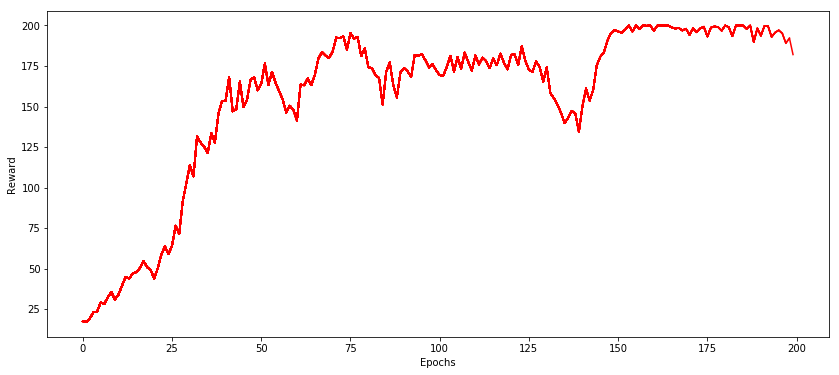

In [10]:
env = gym.make('CartPole-v0')
agent = Agent(4, 'cartpole')
agent.train()
optimiser = optim.Adam(agent.parameters(), lr=1e-3)
discount = 0.99
trace_decay = 0.95
value_loss_weight = 0.5
entropy_loss_weight = 0.01
epochs = 200
rollouts = 32
total_rewards = []

plt.figure(figsize=(14, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

# Converts numpy observations from the environment into a batch Tensor for PyTorch
def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

def plot():
    plt.plot(range(len(total_rewards)), total_rewards, 'r-')
    clear_output(wait=True)
    display(plt.gcf())

for _ in range(epochs):
    optimiser.zero_grad()    
    total_reward = 0
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        values, log_probs_action, rewards, entropies = [], [], [], []  # Collect outputs for training
        while not done:
            # Sample an action from the policy conditioned on the current observation
            policy, value = agent(obs)
            action = policy.sample()
            # Take a step in the enviroment based on the action
            obs, reward, done, _ = env.step(action.item())
            obs = obs_to_tensor(obs)
            total_reward += reward

            # Store outputs that will be used for training
            rewards.append(reward)
            values.append(value)
            log_probs_action.append(policy.log_prob(action))
            entropies.append(policy.entropy())

        # Initialise the final reward and generalised advantage at 0
        ep_return, gae = torch.zeros(1), torch.zeros(1)
        values.append(ep_return)
        trajectory_length = len(rewards)
        loss = 0
        for i in reversed(range(trajectory_length)):  # Calculate the return backwards
            ep_return = rewards[i] + discount * ep_return  # Calculate the return recursively backwards
            advantage = ep_return - values[i]  # Calculate the advantage (used here only for the critic loss)
            loss += value_loss_weight * advantage ** 2
            td_error = rewards[i] + discount * values[i + 1].item() - values[i].item()  # Calculate the TD error
            gae = gae * discount * trace_decay + td_error  # Accumulate the TD error into the generalised advantage
            loss -= log_probs_action[i] * gae  # Use the generalised advantage to weight the policy gradient
            loss -= entropy_loss_weight * entropies[i]  # Encourage higher entropy policies
        loss.backward()  # Accumulate gradients
    optimiser.step()  # Perform batch update

    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

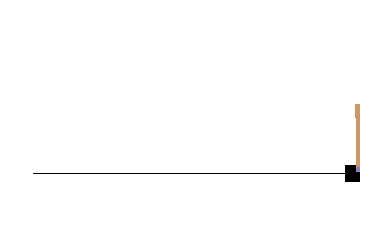

In [11]:
plt.axis('off')

agent.eval()
obs, done = obs_to_tensor(env.reset()), False
view = plt.imshow(env.render(mode='rgb_array'))
while not done:
    view.set_data(env.render(mode='rgb_array'))
    display(plt.gcf())
    clear_output(wait=True)
    with torch.no_grad():
        obs, _, done, _ = env.step(agent(obs)[0].sample().item())
    obs = obs_to_tensor(obs)

env.close()

'Average final reward: -1039.78'

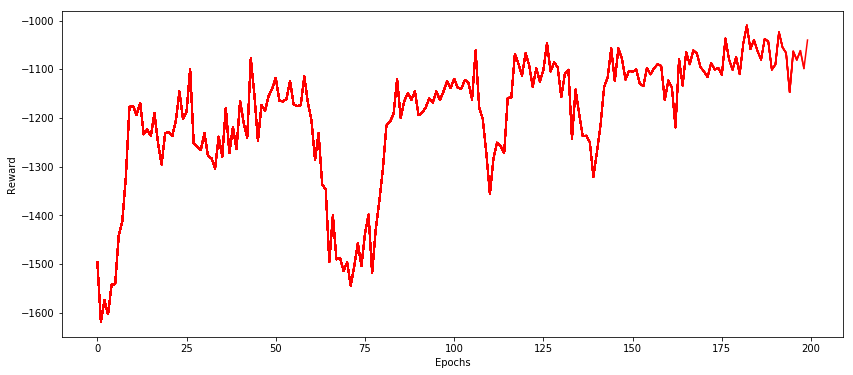

In [12]:
env = gym.make('Pendulum-v0')
agent = Agent(3, 'pendulum')
agent.train()
optimiser = optim.Adam(agent.parameters(), lr=1e-3)
entropy_loss_weight = 0.0001
total_rewards = []

plt.figure(figsize=(14, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

for _ in range(epochs):
    optimiser.zero_grad()
    total_reward = 0
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        values, log_probs_action, rewards, entropies = [], [], [], []
        while not done:
            policy, value = agent(obs)
            action = policy.sample()
            obs, reward, done, _ = env.step([action.item()])
            obs = obs_to_tensor(obs)
            total_reward += reward

            rewards.append(reward)
            values.append(value)
            log_probs_action.append(policy.log_prob(action))
            entropies.append(policy.entropy())

        ep_return, gae = torch.zeros(1), torch.zeros(1)
        values.append(ep_return)
        trajectory_length = len(rewards)
        loss = 0
        for i in reversed(range(trajectory_length)):
            ep_return = rewards[i] + discount * ep_return
            advantage = ep_return - values[i]
            loss += value_loss_weight * advantage ** 2
            td_error = rewards[i] + discount * values[i + 1].item() - values[i].item()
            gae = gae * discount * trace_decay + td_error
            loss -= log_probs_action[i] * gae
            loss -= entropy_loss_weight * entropies[i]
        loss.backward()
    optimiser.step()

    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

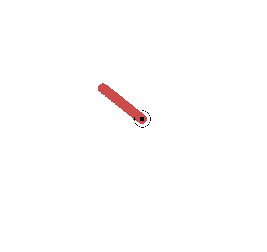

In [13]:
plt.axis('off')

agent.eval()
obs, done = obs_to_tensor(env.reset()), False
view = plt.imshow(env.render(mode='rgb_array'))
while not done:
    view.set_data(env.render(mode='rgb_array'))
    display(plt.gcf())
    clear_output(wait=True)
    with torch.no_grad():
        obs, _, done, _ = env.step([agent(obs)[0].sample().item()])
    obs = obs_to_tensor(obs)

env.close()

## PPO

### Training and Testing

First-order gradients point in the direction of steepest ascent/descent, but the accuracy of this decreases further away from the point of evaluation. A related problem is that a large step size can cause the policy to hop around the optimisation landscape or even get worse. To prevent this, we can restrict how much the policy can change within an update. Trust region policy optimisation (TRPO) defines a hard constraint on this change (the trust region), and uses an approximate second-order method with line search to make sure the policy update never outsteps the trust region. However, this is very expensive, so PPO utilises a first-order method with a soft constraint on the change in the policy.

Both TRPO and PPO perform multiple updates using data collected from rollouts, so use importance sampling to correct for the mismatch as the current policy deviates from the original policy used to collect the data (initially the probability ratio will be 1). However, as the probability ratios increase or diverge within the inner optimisation steps, the objective function becomes more innacurate. Therefore, PPO implements a clipped objective function, which makes the updates conservative and - ideally - more stable.

'Average final reward: -364.33'

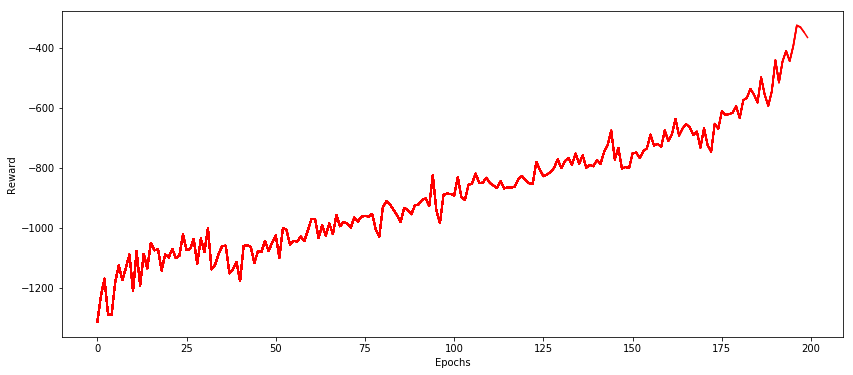

In [14]:
env = gym.make('Pendulum-v0')
agent = Agent(3, 'pendulum')
agent.train()
optimiser = optim.Adam(agent.parameters(), lr=1e-3)
clip = 0.2
total_rewards = []

plt.figure(figsize=(14, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

for _ in range(epochs):
    total_reward = 0

    b_states, b_actions, b_old_log_probs_action, b_returns, b_gaes = [], [], [], [] ,[]  # Collect outputs over a batch
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        # Store states and other info because PPO requires calculating policy and value outputs several times
        states, actions, rewards, returns, old_log_probs_action, values, gaes = [], [], [], [], [], [], []
        with torch.no_grad():
            while not done:
                states.append(obs)

                # Sample an action from the policy conditioned on the current observation
                policy, value = agent(obs)
                action = policy.sample()
                # Take a step in the enviroment based on the action
                obs, reward, done, _ = env.step([action.item()])
                obs = obs_to_tensor(obs)
                total_reward += reward

                # Store outputs that will be used for training
                actions.append(action)
                rewards.append(reward)
                old_log_probs_action.append(policy.log_prob(action))
                values.append(value)

            ep_return, gae = 0, 0
            values.append(torch.zeros(1))
            trajectory_length = len(rewards)
            for i in reversed(range(trajectory_length)):  # Calculate the return backwards
                ep_return = rewards[i] + discount * ep_return
                td_error = rewards[i] + discount * values[i + 1].item() - values[i].item()
                gae = gae * discount * trace_decay + td_error
                returns.insert(0, ep_return)
                gaes.insert(0, gae)

        # Collect data from one episode in the batch
        b_states.append(torch.cat(states))
        b_actions.append(torch.cat(actions))
        b_old_log_probs_action.append(torch.cat(old_log_probs_action))
        b_returns.append(torch.tensor(returns))
        b_gaes.append(torch.tensor(gaes))

    # Batch all data (no need to keep temporal order with a feedforward policy)
    b_states = torch.cat(b_states)
    b_actions = torch.cat(b_actions)
    b_old_log_probs_action = torch.cat(b_old_log_probs_action)
    b_returns = torch.cat(b_returns)
    b_gaes = torch.cat(b_gaes)
    
    for _ in range(10):
        optimiser.zero_grad()
        policies, values = agent(b_states)
        ratios = (policies.log_prob(b_actions) - b_old_log_probs_action).exp()  # Policy ratio
        loss = -torch.min(ratios * b_gaes, torch.clamp(ratios, min=1 - clip, max=1 + clip) * b_gaes).mean()  # Surrogate loss
        loss += value_loss_weight * (b_returns - values).pow(2).mean()
        loss += entropy_loss_weight * policies.entropy().mean()
        loss.backward()
        optimiser.step()

    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

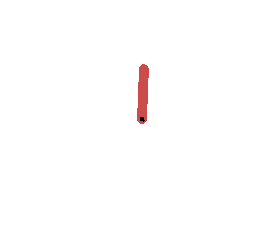

In [15]:
plt.axis('off')

agent.eval()
obs, done = obs_to_tensor(env.reset()), False
view = plt.imshow(env.render(mode='rgb_array'))
while not done:
    view.set_data(env.render(mode='rgb_array'))
    display(plt.gcf())
    clear_output(wait=True)
    with torch.no_grad():
        obs, _, done, _ = env.step([agent(obs)[0].sample().item()])
    obs = obs_to_tensor(obs)

env.close()